## Introduction



**Homography** is useful to find projective transformation: either the scene is *planar* or the *two views were generated by a camera rotating around its center* (same z axis, different x and y axis).

A great tutorial about Homography can be found in OpenCV documentation itself [Feature Detection and Description](https://docs.opencv.org/3.4/db/d27/tutorial_py_table_of_contents_feature2d.html).

If the world scene is not planar, you should definitely NOT use the findHomography function. You can use the *findFundamentalMat* function, which will provide you an estimation of the **fundamental matrix $F$**, the **essential matrix $E$** and **transformation matrix $T$**. These matrixed describes the **epipolar geometry** between the two views. You may use $F$ to rectify your images in order to apply stereo algorithms to determine a dense correspondence map.

The path to find 3D Reconstruction lies upon understand [Epipolar Geometry](https://docs.opencv.org/4.x/da/de9/tutorial_py_epipolar_geometry.html) to find fundamental matrix, applied to [Camera Calibration and 3D Reconstruction](https://docs.opencv.org/4.x/d9/db7/tutorial_py_table_of_contents_calib3d.html).


we we will follow OpenCV tutorial to get this fundamental matrix and then the translation vector $t$ and Rotation matrix $R$ between a pair of stereo images.

## Camera calibration theory

https://docs.opencv.org/4.x/dc/dbb/tutorial_py_calibration.html

Goals:

- Determine the distortion matrix
- Determine the camera matrix: 3x3 matrix which describes the mapping of a pinhole camera from 3D points in the world to 2D points in an image, in terms of focal distances ($f_x , \ f_y$) e optical centers ($c_x, \ c_y$)

![image.png](imgs/ProjectionMatrix.jpg)

$$
s
\begin{bmatrix}
u \\
v \\
1
\end{bmatrix} =
\begin{bmatrix}
K_{3x3}
\end{bmatrix}
\begin{bmatrix}
R_{3x3} & t_{3x1}
\end{bmatrix}
\begin{bmatrix}
X_w \\
Y_w \\
Z_w \\
1
\end{bmatrix}
$$

Note that from the formula above, we still need $t$ and $R$ between the stereo pair reference systems. we will achieve that later, for now let's focus on getting intrinsic matrix, i.e. camera matrix.

In this step, we need to take some photos with the camera of the checkerboard pattern bellow (10 times). This will provide a nice estimation of the focal distance and optical center. If this information is provided by the manufacturer we can simply put this 4 values in the formula of the instrinc properties above. 

![image.png](imgs/pattern.png)


[Epipolar Geometry | Uncalibrated Stereo](https://www.youtube.com/watch?v=6kpBqfgSPRc&t=756s)

![image.png](imgs/epipolarGeometry.png)

Now, assume we have a pair of stereo images (with image sobreposition), one on the left with camera matrix $K_l$ and one on the right with camera matrix $K_r$

We can obtain the image coordinates $u_l$ and $u_r$ from real world coordinates $x_l$ and $x_r$ with

![image.png](imgs/formula1.png)

We are trying to caulculate this essential matrix, that can be decomposed in translation and rotation matrix like this:

![image.png](imgs/essentialMatrix.png)

Remember that we have the same point in the left image coordinates system and on the right image coordinate system, $u_l$ and $u_r$. Also $K_l$ and $K_r$.

Using Epipolar constraint, we reach essential matrix. 

![image.png](imgs/essentialMatrix2.png)

1) Now, we have a very simple expression: ${\bf u_l}^T [F] {\bf u_r}=0$.

2) When we find fundamental matrix $[F]$, is easy to find essential matrix with: $E = K_l^T [F] K_r$

3) And once we find essential matrix, we use Singular Value Decomposition (SVD) to find $T$ (skew simmetric matrix) and $R$ (orthonormal matrix). 

4) Finnaly with $T$, we get translation vector $t$ just by: $t_x = -T[2,3]$, $t_y = T[1,3]$ and $t_z = -T[1,2]$

The fundamental matrix thus enables projective 3D reconstruction of the captured scene. If the calibration is known, estimating the essential matrix enables metric 3D reconstruction of the captured scene.

### One solution for ${\bf u_l}^T [F] {\bf u_r}=0$ 

https://www.youtube.com/watch?v=izpYAwJ0Hlw

The fundamental matrix $F$ encapsulates this intrinsic geometry, which is a 3×3 matrix of rank 2. If a 3D point X is projected as ${\bf u_l}$ in the first view, and ${\bf u_r}$ in the second, then we have the following relation:

$$
{\bf u_l}^T [F] {\bf u_r}=0 \\
$$

Note that multiply both sides by a constant $k$, doesn't change the result. So ${\bf f}$ is defined by fixing it's normal to 1:

Each pair of points correspondence gives rise to one linear equation. Specifically, writing ${\bf u_l}$=($u_l$ , $v_l$, $1$), and ${\bf u_r}$=($u_r$ , $v_r$, $1$), this equation can be written in terms of the known coordinates ${\bf u_l}$ and ${\bf u_r}$.
$$

\begin{bmatrix}
u_l & v_l & 1
\end{bmatrix}
\begin{bmatrix}
f_{11} & f_{12} & f_{13}\\
f_{21} & f_{22} & f_{23}\\
f_{31} & f_{32} & f_{33}
\end{bmatrix}
\begin{bmatrix}
u_r\\
v_r\\
1
\end{bmatrix} =0 \\

\begin{bmatrix}
u_l f_{11} & u_l f_{12} & u_l f_{13}\\
v_l f_{21} & v_l f_{22} & v_l f_{23}\\
f_{31} & f_{32} & f_{33}
\end{bmatrix}
\begin{bmatrix}
u_r\\
v_r\\
1
\end{bmatrix} =0

\begin{bmatrix}
u_l f_{11} u_r + u_l f_{12} v_r + u_l f_{13}\\
v_l f_{21} u_r + v_l f_{22} v_r + v_l f_{23}\\
f_{31} u_r + f_{32} v_r + f_{33}
\end{bmatrix} = 
\begin{bmatrix}
0  \\
0  \\
0
\end{bmatrix} \\
$$

Which can be grouped in a single equation like this:

$$
u_l f_{11} u_r + u_l f_{12} v_r + u_l f_{13} + v_l f_{21} u_r + v_l f_{22} v_r + v_l f_{23} + f_{31} u_r + f_{32} v_r + f_{33} = 0
$$


Organizing $f_{ij}$ in a single vector we have this for each pair of points:

$$
\begin{bmatrix}
u_l u_r & u_l  v_r & u_l & v_l u_r & v_l v_r & v_l &  u_r & v_r & 1
\end{bmatrix}
\begin{bmatrix}
f_{11} \\
f_{12} \\
f_{13} \\
f_{21} \\
f_{22} \\
f_{23} \\
f_{31} \\
f_{32} \\
f_{33} \\
\end{bmatrix}
= 0
$$

Which for our whole set of $n$ known points we have:

$$
\begin{bmatrix}
u^1_l u^1_r & u^1_l v^1_r & u^1_l & v^1_l u^1_r & v^1_l v^1_r & v^1_l & u^1_r & v^1_r & 1 \\
& & & &\vdots \\
u^n_l u^n_r & u^n_l v^n_r & u^n_l & v^n_l u^n_r & v^n_l v^n_r & v^n_l & u^n_r & v^n_r & 1
\end{bmatrix}
\begin{bmatrix}
f_{11} \\
f_{12} \\
f_{13} \\
f_{21} \\
f_{22} \\
f_{23} \\
f_{31} \\
f_{32} \\
f_{33} \\
\end{bmatrix}
= 0 \\
A {\bf f} = 0
$$

Since we have 9 unkowns and more than 9 equations, we have here a problem of Least-squares adjustment:

$$
A {\bf f_a} = V \\
$$


Onde $V$ é um vetor de resíduos (erros) a ser minimizado pelo método MMQ ($\Phi = V^T V = mín$):

Assim:

$$
\Phi = V^T V = mín\\
\Phi = {\bf f_a}^T A^T A {\bf f_a} = mín
$$

But with the condition $||{\bf f}||^2 = 1 \rightarrow ||{\bf f_a}||^2 = {\bf f_a}^T{\bf f_a} \approx 1$ we have to introduce a new regularization term for convenience :

$$
{\bf f_a}^T{\bf f_a}-1  \approx 0 \\
\lambda({\bf f_a}^T{\bf f_a}-1) I = mín \\
$$

One equation with both tradeoffs:

$$
\mathcal{L} = {\bf f_a}^T A^T A {\bf f_a} - \lambda({\bf f_a}^T{\bf f_a}-1) I = mín \\
$$

Here, $\lambda$ is a Lagrange multiplier enforcing the constraint $||{\bf f}||^2 = 1$.


Set to zero the derivative of above equation $\mathcal{L}$ to find the minimum:

$$
\frac{d \mathcal{L}}{d {\bf f}} = 2 A^T A {\bf f_a} -2 \lambda {\bf f_a} = 0 \\

A^T A {\bf f_a} =\lambda {\bf f_a}
$$

This is an eigenvalue problem, where ${\bf f_a}$ is an eigenvector of 
$A^TA$, and $\lambda$ is the corresponding eigenvalue.


## Camera essential Matrix - Steps

## Get camera essential Matrix

Here we used the same camera in two different positions, wich can be interpreted as two cameras with the same camera matrix ($K_l=K_r$) that we already know.

## Get new position of the camera with 

### $$ X_l = R X_r + t$$

Note that the matrix form of an affine transformation is a 4-by-4 matrix with the fourth row 0, 0, 0, and 1. In other words:

$$ 
\begin{bmatrix}
x_l \\
y_l \\
z_l \\
1
\end{bmatrix}_{4x1} =
\underbrace{
    \begin{bmatrix}
        R_{3x3} & t_{3x1} \\
        0_{1x3} & 1 
    \end{bmatrix}
}_{T_{4x4}}
\begin{bmatrix}
x_r \\
y_r \\
z_r \\
1
\end{bmatrix}_{4x1}$$


## Get world coordinates $[X_w \ Y_w \ Z_w]$ from image coordinates $[u_l \ v_l] $

Remember the formula on [Camera Calibration](#camera-calibration-theory)?

$$
s
\begin{bmatrix}
u \\
v \\
1
\end{bmatrix} =
\begin{bmatrix}
K_{3x3}
\end{bmatrix}
\begin{bmatrix}
R_{3x3} & t_{3x1}
\end{bmatrix}
\begin{bmatrix}
X_w \\
Y_w \\
Z_w \\
1
\end{bmatrix}
$$

$$
s
\begin{bmatrix}
u \\
v \\
1
\end{bmatrix} =
\begin{bmatrix}
K_{3x3} & 0
\end{bmatrix}_{3x4}
\begin{bmatrix}
R_{3x3} & t_{3x1} \\
[0]_{1x3} & 1
\end{bmatrix}_{4x4}
\begin{bmatrix}
X_w \\
Y_w \\
Z_w \\
1
\end{bmatrix}
$$



## Camera calibration code 

```shell
#!/bin/bash
for i in {8..15}
do
    #0 - CR
    #fswebcam --no-banner --flip h,v -S 10 -s brightness=60% -r 1920x1080  --device /dev/video0 raspfotos/img$i-video0.jpg
    #1 - R
    fswebcam --no-banner -S 10 -s brightness=80% -r 1920x1080 --device /dev/video1 raspfotos/img$i-video1.jpg
    #3 - L
    fswebcam --no-banner -S 10 -s brightness=80% -r 1920x1080  --device /dev/video3 raspfotos/img$i-video3.jpg
    #5 - CL
    #fswebcam --no-banner -S 10 -s brightness=60% -r 1920x1080  --device /dev/video5 raspfotos/img$i-video5.jpg
    echo -n 'Press any key to continue. Press n to break: '
    read goon
    if [[ $goon == 'n' ]]
    then
        break
    fi
    goon=
done
```

In [8]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import time
import os
from tqdm import tqdm

In [13]:
def print_table(matrix):
    s = [[str(e) for e in row] for row in matrix]
    lens = [max(map(len, col)) for col in zip(*s)]
    fmt = '\t'.join('{{:{}}}'.format(x) for x in lens)
    table = [fmt.format(*row) for row in s]
    print('\n'.join(table))

def form_transf(R, t):
        """
        Makes a transformation matrix from the given rotation matrix and translation vector

        Parameters
        ----------
        R (ndarray): The rotation matrix
        t (list): The translation vector

        Returns
        -------
        T (ndarray): The transformation matrix
        """
        T = np.eye(4, dtype=np.float64)
        T[:3, :3] = R
        T[:3, 3] = t
        return T

def decomp_essential_mat(E, q1, q2, K):
        """
        Decompose the Essential matrix

        Parameters
        ----------
        E (ndarray): Essential matrix
        q1 (ndarray): The good keypoints matches position in i-1'th image
        q2 (ndarray): The good keypoints matches position in i'th image

        Returns
        -------
        right_pair (list): Contains the rotation matrix and translation vector
        """


        R1, R2, t = cv2.decomposeEssentialMat(E)
        T1 = form_transf(R1,np.ndarray.flatten(t))
        T2 = form_transf(R2,np.ndarray.flatten(t))
        T3 = form_transf(R1,np.ndarray.flatten(-t))
        T4 = form_transf(R2,np.ndarray.flatten(-t))
        transformations = [T1, T2, T3, T4]
        
        # Homogenize K
        K = np.concatenate(( K, np.zeros((3,1)) ), axis = 1)

        # List of projections
        projections = [K @ T1, K @ T2, K @ T3, K @ T4]

        np.set_printoptions(suppress=True)

        # print ("\nTransform 1\n" +  str(T1))
        # print ("\nTransform 2\n" +  str(T2))
        # print ("\nTransform 3\n" +  str(T3))
        # print ("\nTransform 4\n" +  str(T4))

        positives = []
        for P, T in zip(projections, transformations):
            hom_Q1 = cv2.triangulatePoints(P, P, q1.T, q2.T)
            hom_Q2 = T @ hom_Q1
            # Un-homogenize
            Q1 = hom_Q1[:3, :] / hom_Q1[3, :]
            Q2 = hom_Q2[:3, :] / hom_Q2[3, :]  

            total_sum = sum(Q2[2, :] > 0) + sum(Q1[2, :] > 0)
            relative_scale = np.mean(np.linalg.norm(Q1.T[:-1] - Q1.T[1:], axis=-1)/
                                     np.linalg.norm(Q2.T[:-1] - Q2.T[1:], axis=-1))
            positives.append(total_sum + relative_scale)
            

        # Decompose the Essential matrix using built in OpenCV function
        # Form the 4 possible transformation matrix T from R1, R2, and t
        # Create projection matrix using each T, and triangulate points hom_Q1
        # Transform hom_Q1 to second camera using T to create hom_Q2
        # Count how many points in hom_Q1 and hom_Q2 with positive z value
        # Return R and t pair which resulted in the most points with positive z

        max = np.argmax(positives)
        if (max == 2):
            # print(-t)
            return R1, np.ndarray.flatten(-t)
        elif (max == 3):
            # print(-t)
            return R2, np.ndarray.flatten(-t)
        elif (max == 0):
            # print(t)
            return R1, np.ndarray.flatten(t)
        elif (max == 1):
            # print(t)
            return R2, np.ndarray.flatten(t)

In [22]:
folder  = 'calib_data/calib_photos_Pi_NOIR_2.1/'

## Open 10 different images from the checkerboard and camera matrix
# Define the dimensions of checkerboard 
CHECKERBOARD = (6, 9) 

# stop the iteration when specified 
# accuracy, epsilon, is reached or 
# specified number of iterations are completed. 
criteria = (cv2.TERM_CRITERIA_EPS +
			cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001) 

# Vector for 3D points 
threedpoints = [] 

# Vector for 2D points 
twodpoints = [] 

# 3D points real world coordinates 
objectp3d = np.zeros((1, CHECKERBOARD[0] 
					* CHECKERBOARD[1], 
					3), np.float32) 
objectp3d[0, :, :2] = np.mgrid[0:CHECKERBOARD[0], 
							0:CHECKERBOARD[1]].T.reshape(-1, 2) 
prev_img_shape = None


# Extracting path of individual image stored 
# in a given directory. Since no path is 
# specified, it will take current directory 
# jpg files alone 
images = [folder + f for f in os.listdir(folder) if ".jpg" in f]

print("Openning checkerbooard photos taken...")
for filename in tqdm(images): 
	image = cv2.imread(filename) 
	grayColor = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) 

	# Find the chess board corners 
	# If desired number of corners are 
	# found in the image then ret = true 
	ret, corners = cv2.findChessboardCorners( 
					grayColor, CHECKERBOARD, 
					cv2.CALIB_CB_ADAPTIVE_THRESH 
					+ cv2.CALIB_CB_FAST_CHECK +
					cv2.CALIB_CB_NORMALIZE_IMAGE) 

	# If desired number of corners can be detected then, 
	# refine the pixel coordinates and display 
	# them on the images of checker board 
	if ret == True: 
		threedpoints.append(objectp3d) 

		# Refining pixel coordinates 
		# for given 2d points. 
		corners2 = cv2.cornerSubPix( 
			grayColor, corners, (11, 11), (-1, -1), criteria) 

		twodpoints.append(corners2) 

		# Draw and display the corners 
		image = cv2.drawChessboardCorners(image, 
										CHECKERBOARD, 
										corners2, ret)

	cv2.imshow('img', image)
	cv2.waitKey(50) 

cv2.destroyAllWindows() 

h, w = image.shape[:2] 

# Perform camera calibration by 
# passing the value of above found out 3D points (threedpoints) 
# and its corresponding pixel coordinates of the 
# detected corners (twodpoints) 
print("Calibrating...") 
ret, matrix, distortion, r_vecs, t_vecs = cv2.calibrateCamera( 
	threedpoints, twodpoints, grayColor.shape[::-1], None, None) 

# Displaying required output 
print(" Camera matrix:") 
print_table(matrix)

print("\n Distortion coefficient:") 
print_table(distortion) 

# print("\n Rotation Vectors:") 
# pprint(r_vecs) 

# print("\n Translation Vectors:") 
# pprint(t_vecs) 

Openning checkerbooard photos taken...


100%|██████████| 13/13 [00:01<00:00,  8.14it/s]


Calibrating...
 Camera matrix:
2133.117742548749	0.0              	645.9251704496461
0.0              	2119.441021648427	434.6530541423573
0.0              	0.0              	1.0              

 Distortion coefficient:
-0.033783641398448895	-0.7810268029048288	-0.011067952419731217	-0.01946824511038794	2.573869193145069


### Undistortion

In [23]:
print(images[-1])
img = cv2.imread(images[-1])
h,  w = img.shape[:2]
newcameramtx, roi = cv2.getOptimalNewCameraMatrix(matrix, distortion, (w,h), 1, (w,h))
print("New Camera matrix:") 
print_table(newcameramtx)
print(roi)

# undistort
dst = cv2.undistort(img, matrix, distortion, None, newcameramtx)
 
# crop the image
x, y, w, h = roi
dst = dst[y:y+h, x:x+w]
cv2.imwrite('calibresult.png', dst)

# Re-projection Error
mean_error = 0
for i in range(len(threedpoints)):
    imgpoints2, _ = cv2.projectPoints(threedpoints[i], r_vecs[i], t_vecs[i], newcameramtx, distortion)
    error = cv2.norm(twodpoints[i], imgpoints2, cv2.NORM_L2)/len(imgpoints2)
    mean_error += error
 
print( "total error: {}".format(mean_error/len(threedpoints)) )

calib_data/calib_photos_PC_CAM_OV1320_V1.1/04.jpg
New Camera matrix:
2100.1340708590365	0.0              	635.8337808758629
0.0               	2043.592508310838	426.4742598795698
0.0               	0.0              	1.0              
(8, 19, 1869, 1023)
total error: 2.3881535068698376


In [24]:
# Save
with open(folder+'camera_matrix.npy', 'wb') as f:
    np.savetxt(f, newcameramtx)
with open(folder+'distortion_coefficient.npy', 'wb') as f:
    np.savetxt(f, distortion)


## If calibrated, start from here

In [8]:
with open(folder+'camera_matrix.npy', 'rb') as f:
    matrix = np.loadtxt(f)
with open(folder+'distortion_coefficient.npy', 'rb') as f:
    distortion = np.loadtxt(f)

### Take 2 pictures of the same view from different angles

In [9]:
if not jump_take_photos_for_calibration:
    cap = cv2.VideoCapture(0, cv2.CAP_DSHOW)
    captures = 0
    images = []
    print("Start capturing...")
    while captures <= 1:
        # Capture frame-by-frame
        ret, frame = cap.read()

        if (ret):
            # Display the resulting frame
            cv2.imshow('Cam 0', frame)

        if cv2.waitKey(1) & 0xFF == ord(' '):
            print(frame.shape)
            cv2.imwrite(f'f_{captures+1:02d}.jpg', frame)
            images.append(frame)
            captures +=1

    # When everything is done, release the capture
    cap.release()
    cv2.destroyAllWindows()

### Get Key points in both images

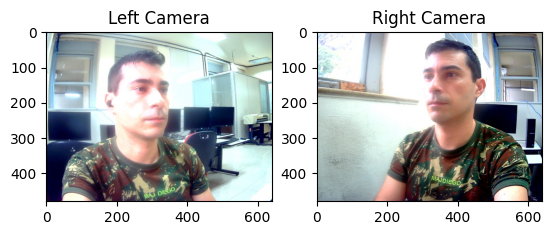

In [10]:
# show images
images = []
for captures in [0,1]:
    frame = cv2.imread(f'f_{captures+1:02d}.jpg')
    images.append(frame)

f,(ax1,ax2) = plt.subplots(1,2)
ax1.imshow(cv2.cvtColor(images[0],cv2.COLOR_BGR2RGB))
ax2.imshow(cv2.cvtColor(images[1],cv2.COLOR_BGR2RGB))
ax1.set_title("Left Camera")
ax2.set_title("Right Camera")
plt.show()

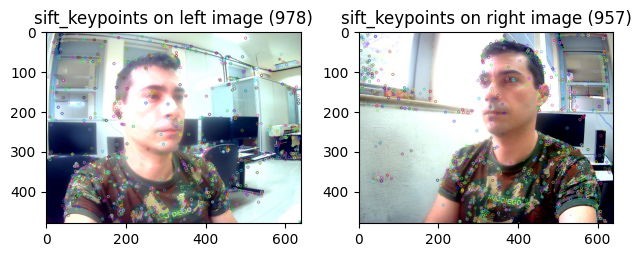

In [11]:
# Detect keypoints and compute descriptors
rgb_l = cv2.cvtColor(images[0],cv2.COLOR_BGR2RGB)
gray_l = cv2.cvtColor(rgb_l,cv2.COLOR_RGB2GRAY)

rgb_r = cv2.cvtColor(images[1],cv2.COLOR_BGR2RGB)
gray_r = cv2.cvtColor(rgb_r,cv2.COLOR_RGB2GRAY)

sift = cv2.SIFT_create()

# Detect keypoints and compute descriptors
kp1, des1 = sift.detectAndCompute(gray_l,None)
img1 = cv2.drawKeypoints(rgb_l, kp1, images[0])
kp2, des2 = sift.detectAndCompute(gray_r,None)
img2 = cv2.drawKeypoints(rgb_r, kp2, images[1])

f, ax = plt.subplots(1,2)
f.tight_layout() 
ax[0].imshow(img1)
ax[0].set_title(f"sift_keypoints on left image ({len(des1)})")
ax[1].imshow(img2)
ax[1].set_title(f"sift_keypoints on right image ({len(des2)})")
plt.show()

### Match key points in these two images

Good matches: 978


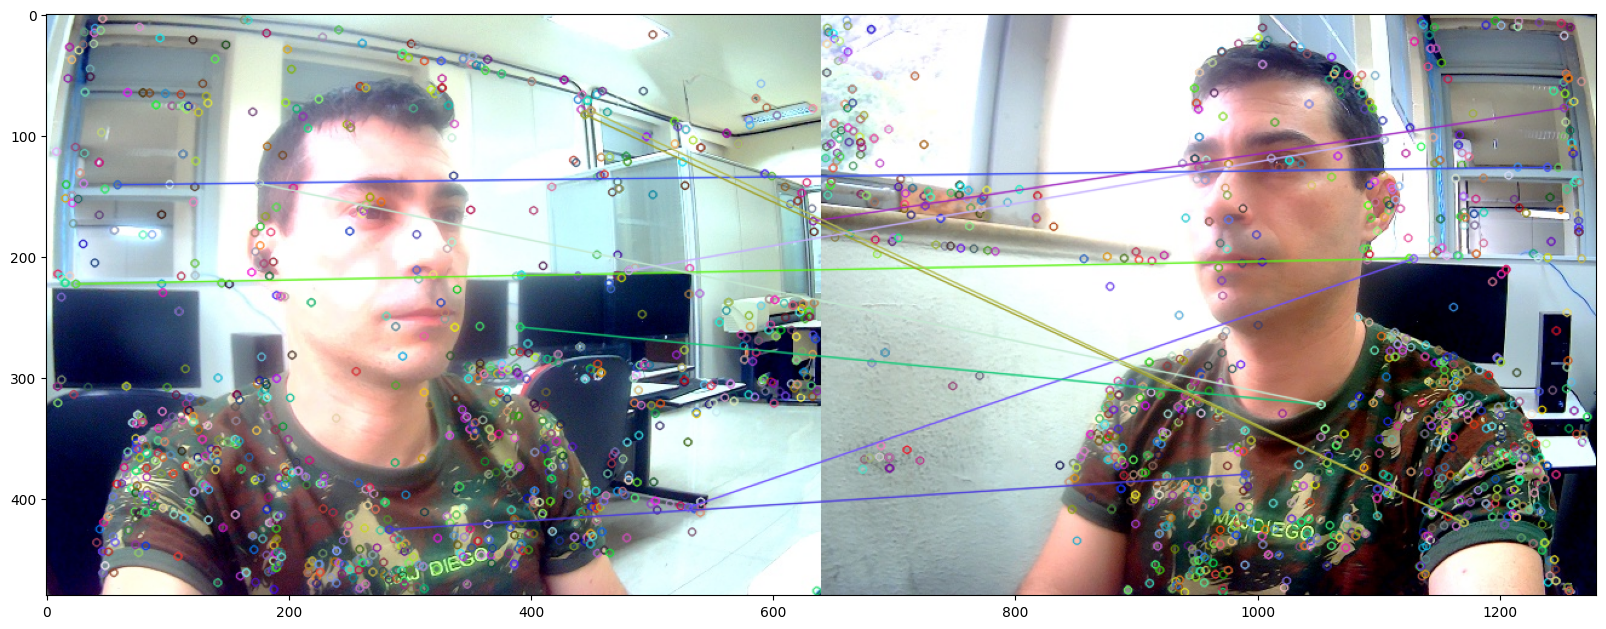

In [12]:
# https://docs.opencv.org/3.4/dc/dc3/tutorial_py_matcher.html
## Basic Brute-Force Matcher
# create BFMatcher object
bf = cv2.BFMatcher()
# Match descriptors.
matches = bf.match(des1,des2)
# Sort them in the order of their distances. --> Lower is better 
matches = sorted(matches, key = lambda x:x.distance)
print("Good matches:",len(matches))
# Draw first 10 matches.
img3 = cv2.drawMatches(img1,kp1,img2,kp2,matches[:10],None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
f, a = plt.subplots(figsize = (20,8))
plt.imshow(img3)
plt.show()

Just horrible... and Fundamental Matrix estimation is sensitive to quality of matches, outliers etc. It becomes worse when all selected matches lie on the same plane. wich is not he case.

Good matches: 36


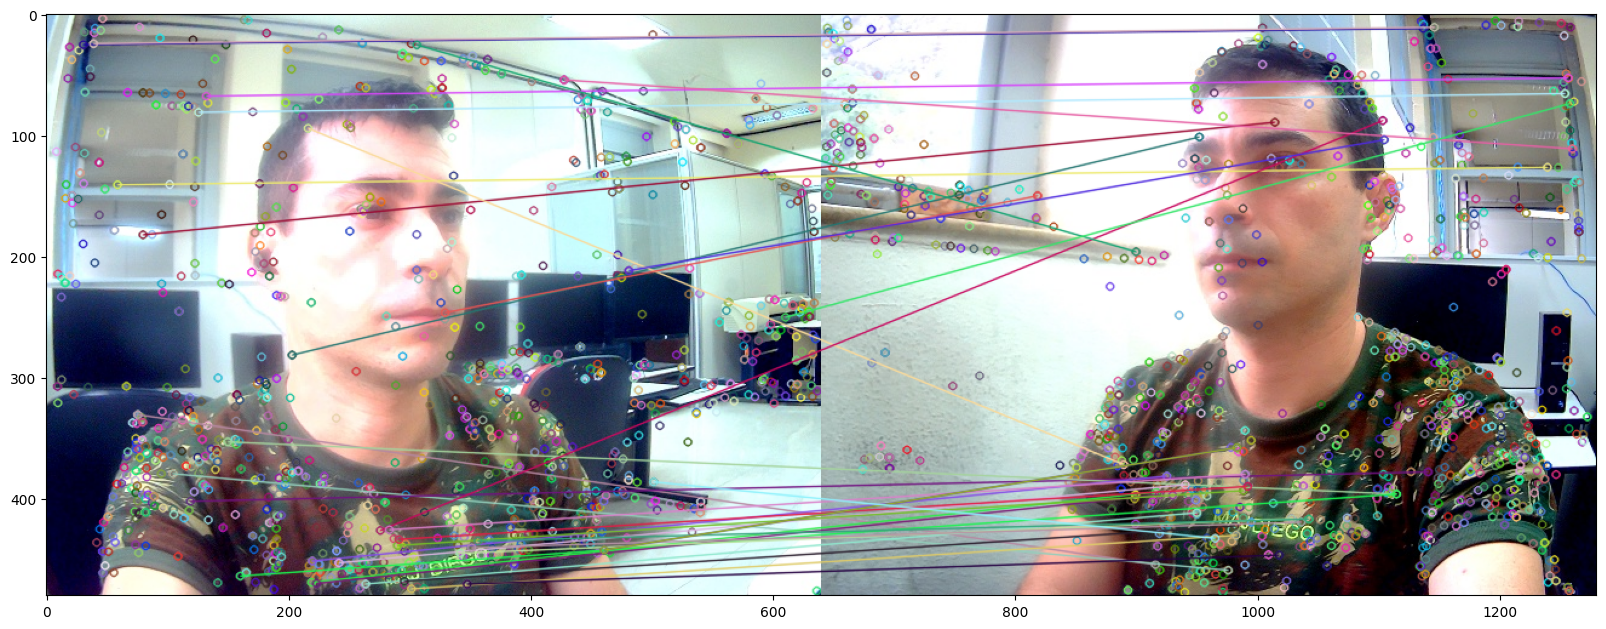

In [13]:
# https://docs.opencv.org/3.4/dc/dc3/tutorial_py_matcher.html
## Basic Brute-Force Matcher
# create BFMatcher object
bf = cv2.BFMatcher()
# Match descriptors.
matches = bf.knnMatch(des1,des2,k=2)
# Apply ratio test
threshold = 0.75 # tweak treshhold to better results
good = []
for m,n in matches:
    if m.distance < threshold*n.distance:
        good.append([m])
print("Good matches:",len(good))
# cv.drawMatchesKnn expects list of lists as matches.
img3 = cv2.drawMatchesKnn(img1,kp1,img2,kp2,good,None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
f, a = plt.subplots(figsize = (20,8))
plt.imshow(img3)
plt.show()

### Equations

In [14]:
ul = np.float32([ kp1[m[0].queryIdx].pt for m in good ])
ur = np.float32([ kp2[m[0].trainIdx].pt for m in good ])

# Compute fundamental matrix
F, mask = cv2.findFundamentalMat(ul, ur, cv2.FM_RANSAC, 3, 0.99)
print("F:")
print_table(F)
print("\nEssential matrix from fundamental matrix:")
print_table(matrix.T @ F @ matrix)

# another solution (thanks openCV !!!!)
E, mask = cv2.findEssentialMat(ul, ur, matrix)
print("\nOpen CV Essential matrix:")
print_table(E)

F:
2.091407609478974e-06  	1.968077667477e-05    	-0.002332359166235492
-1.0333406792380093e-05	1.4195516147223629e-05	-0.01221134784020879 
0.0010339893043636585  	-0.0003786263586335979	1.0                  

Essential matrix from fundamental matrix:
0.40630847031099343 	3.829739661435388	1.2020342930079209 
-2.010807727992592  	2.76686541017041 	-5.506967997402771 
-0.25076741400971586	4.09413010746331 	-0.6105038391711806

Open CV Essential matrix:
-0.04757377280845876	-0.026257492867391416	0.08899533626177439 
0.3177908233795608  	-0.09753793153802828 	-0.6166027818220194 
0.0662711531933155  	0.6993529998000698   	-0.07026364774322819


In [15]:
R, t = decomp_essential_mat(E, ul, ur, matrix)
print("\nR:")
print_table(R)
print("\nt:")
print_table([t])

# set x_r
xr = np.array([0, 0, 0, 1])

# arrange T
T = np.eye(4, dtype=np.float64)
T[:3, :3] = R
T[:3, 3] = t
# or
# T = np.hstack((R,t.reshape(t.shape[0],1)))
print("\nTransformation matrix (T):")
print_table(T)

xl = T @ xr
print("\nxr:",xr)
print("\nxl:",xl)


R:
0.8886094998261482  	-0.1796731547800156	0.4220079552213671   
0.21726324644812267 	0.9751966343438125 	-0.042287186088958234
-0.40394286546681846	0.1292636136578925 	0.905605366383481    

t:
0.9890673489027346	0.13635508011343547	0.05615221689100768

Transformation matrix (T):
0.8886094998261482  	-0.1796731547800156	0.4220079552213671   	0.9890673489027346 
0.21726324644812267 	0.9751966343438125 	-0.042287186088958234	0.13635508011343547
-0.40394286546681846	0.1292636136578925 	0.905605366383481    	0.05615221689100768
0.0                 	0.0                	0.0                  	1.0                

xr: [0 0 0 1]

xl: [0.98906735 0.13635508 0.05615222 1.        ]


C:\Windows\Temp\ipykernel_6216\1724244643.py:78: RuntimeWarning: invalid value encountered in divide
  relative_scale = np.mean(np.linalg.norm(Q1.T[:-1] - Q1.T[1:], axis=-1)/


In [17]:
_, _, P1, P2, Q, _, _ = cv2.stereoRectify(matrix, distortion, matrix, distortion, (gray_l.shape), R, t)
P1, P2, Q

NameError: name 'gray_l' is not defined

In [10]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

gray_l = cv2.imread("imgs/CL.jpg")
gray_r = cv2.imread("imgs/CR.jpg")
gray_l.shape, gray_r.shape

((1080, 1920, 3), (1080, 1920, 3))

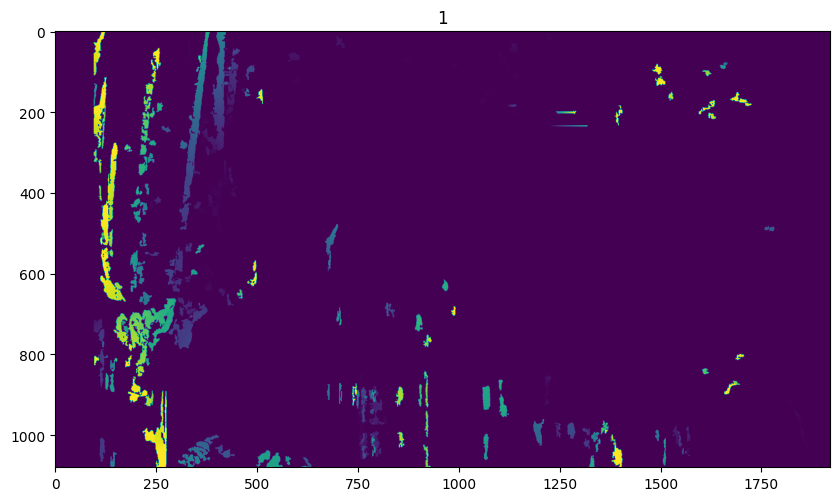

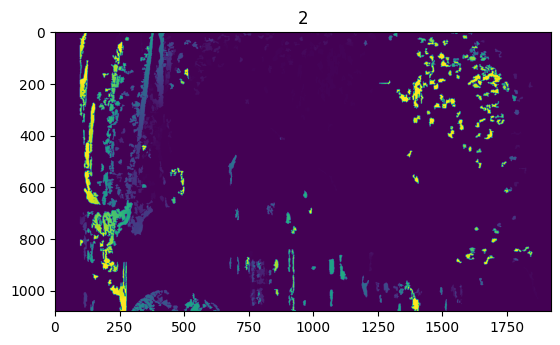

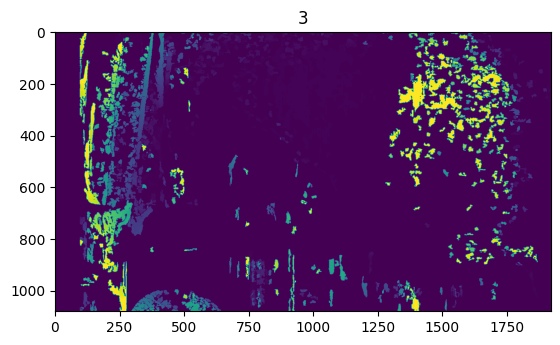

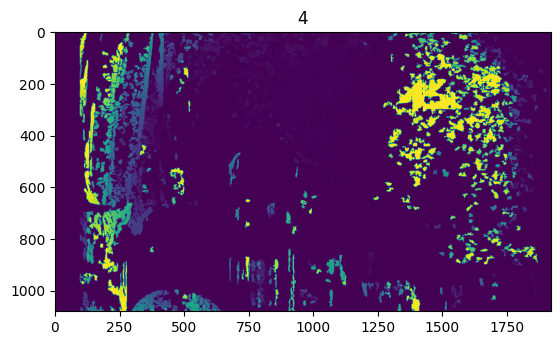

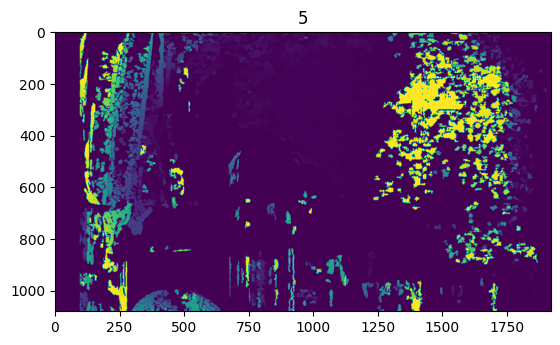

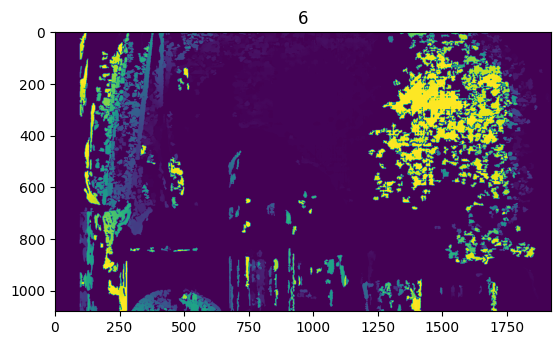

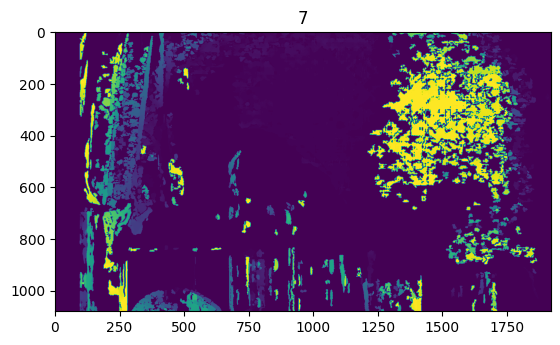

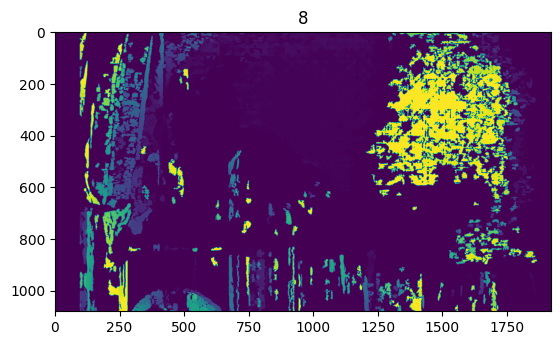

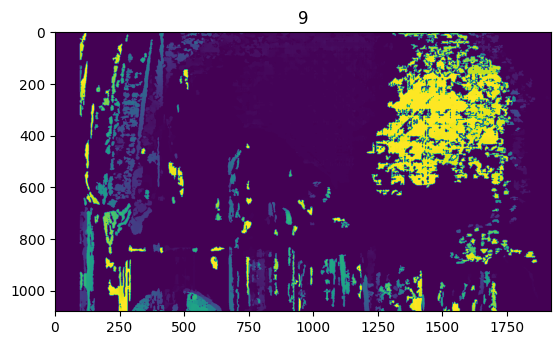

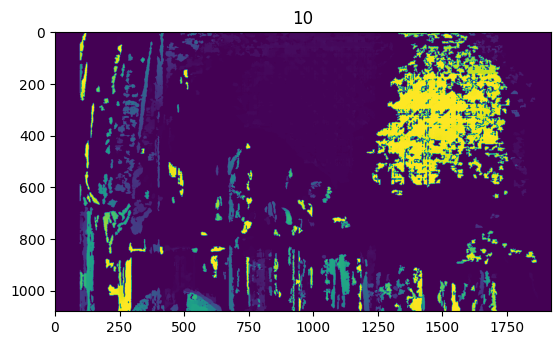

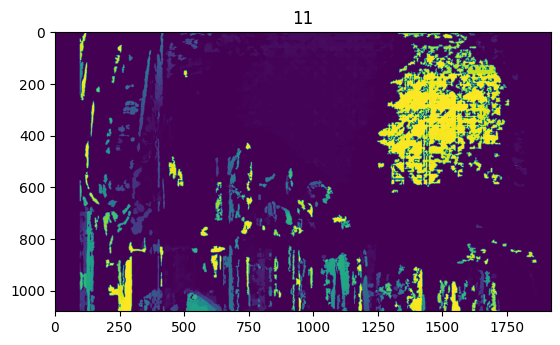

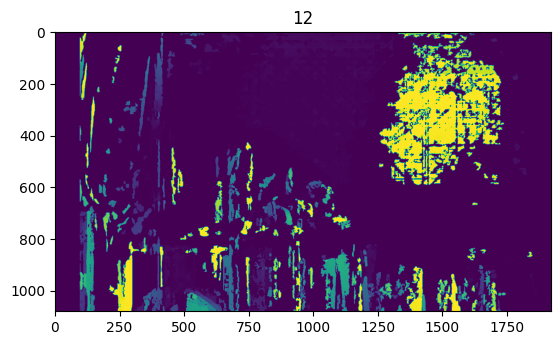

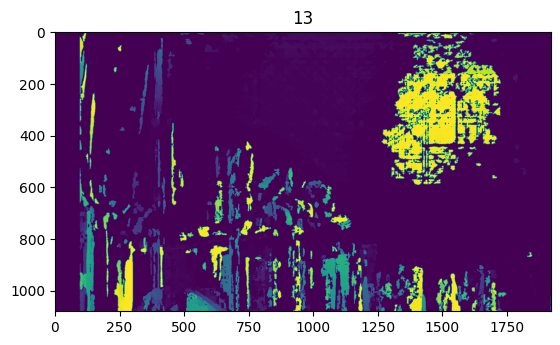

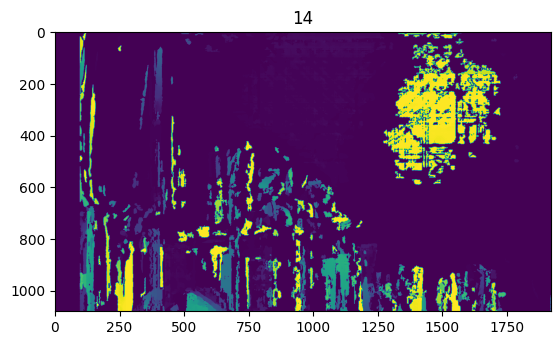

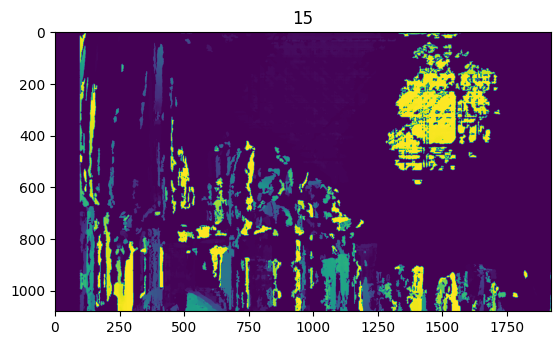

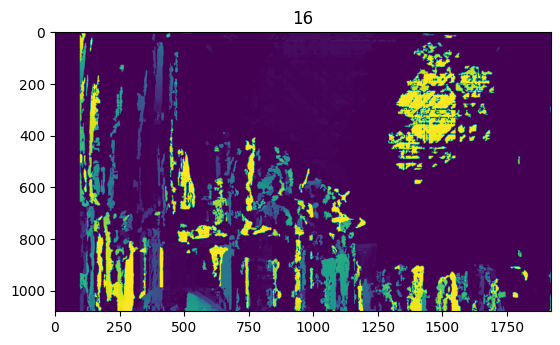

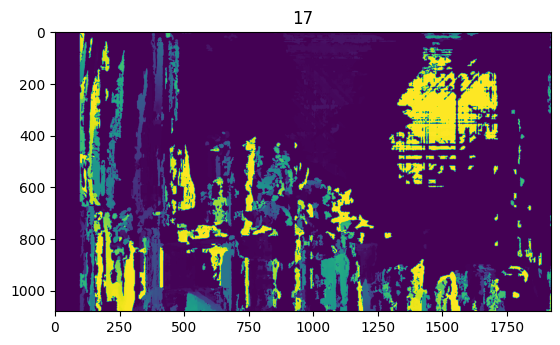

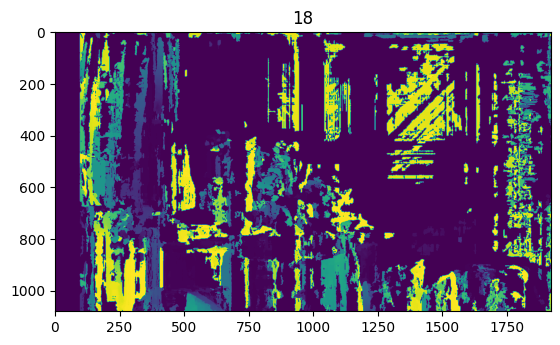

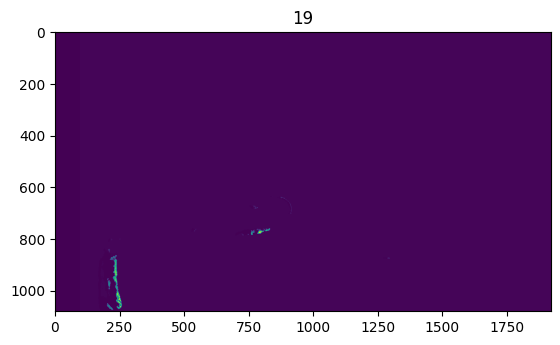

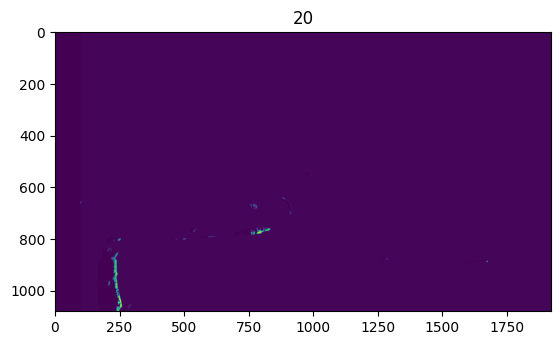

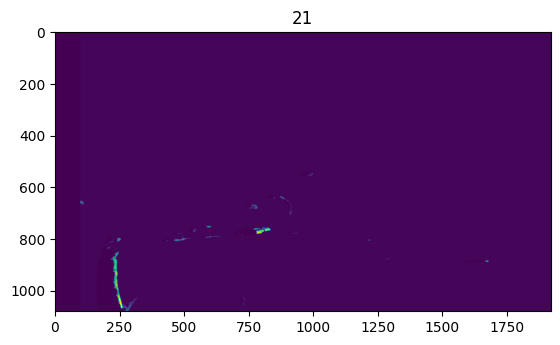

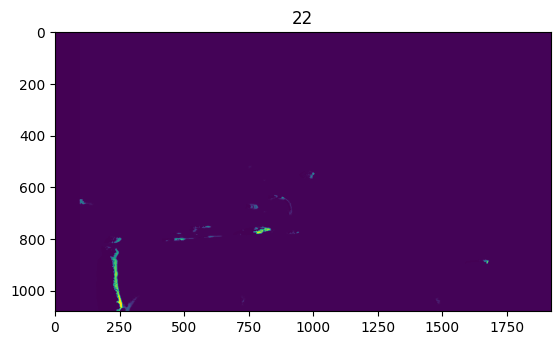

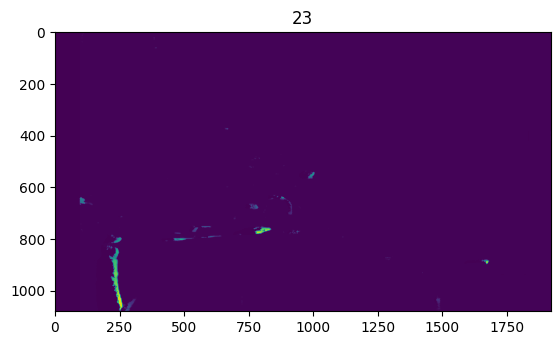

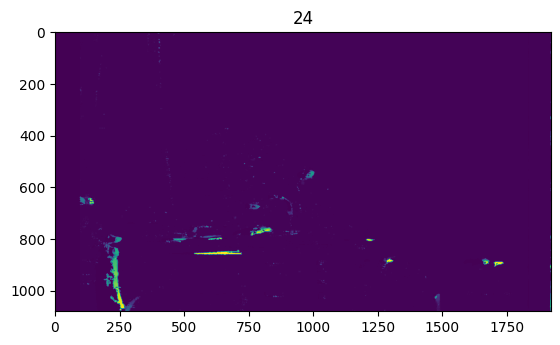

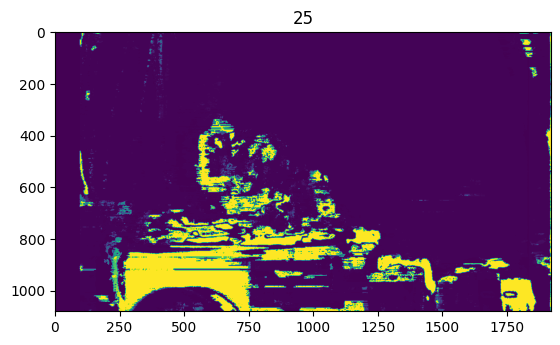

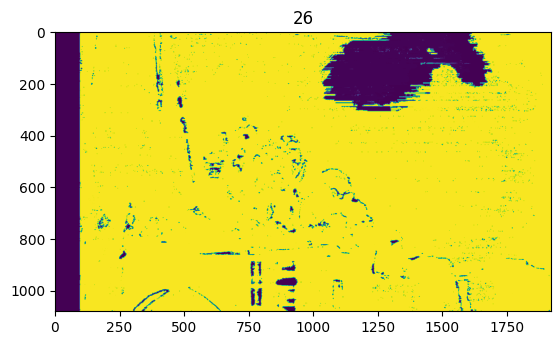

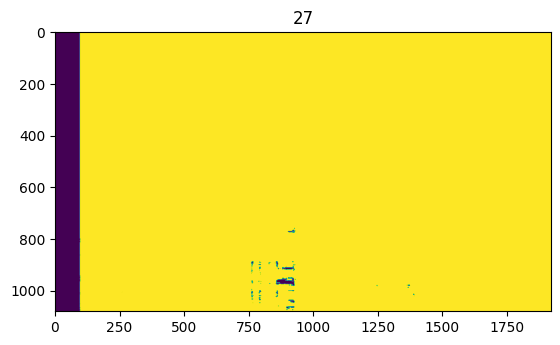

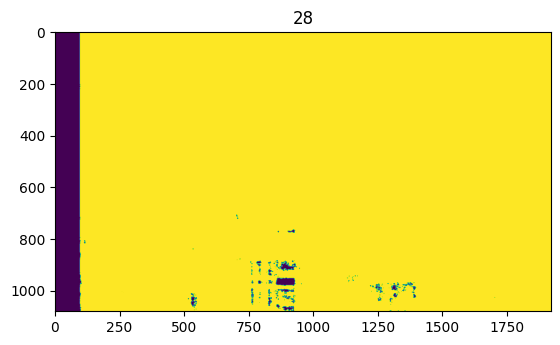

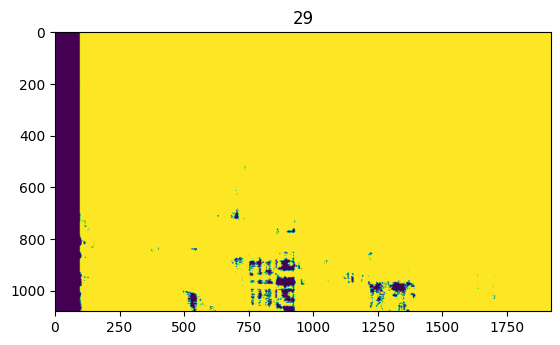

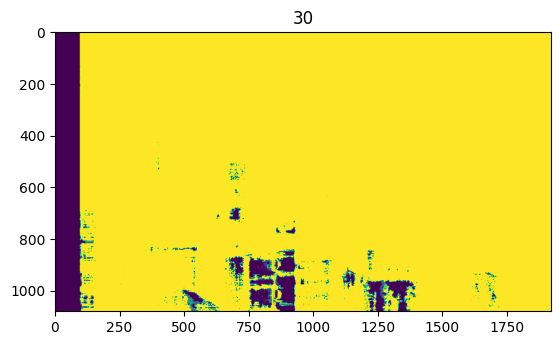

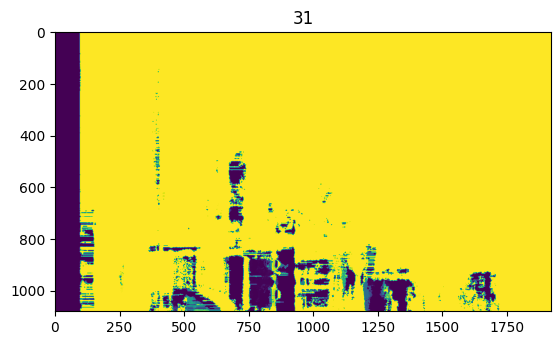

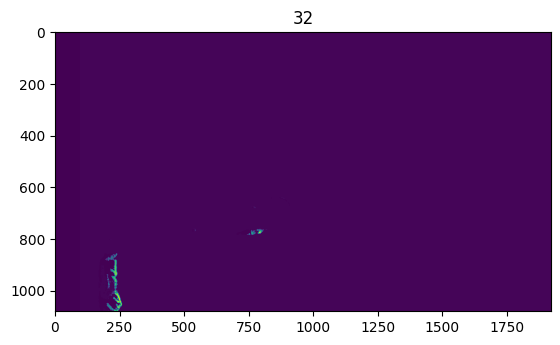

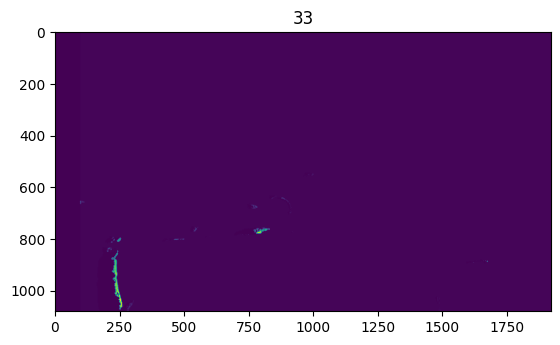

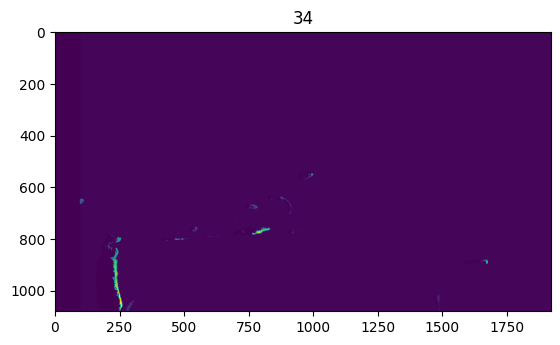

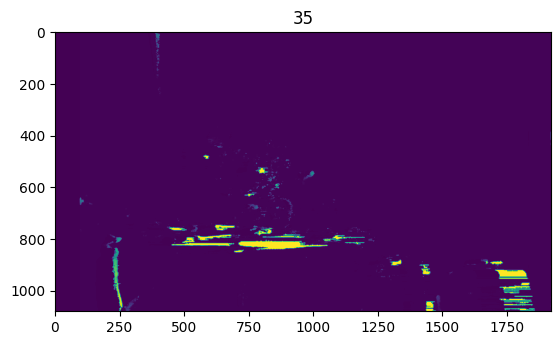

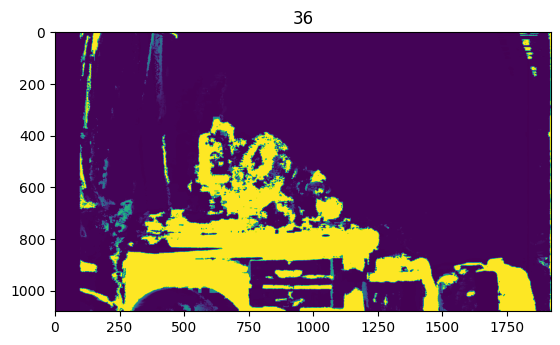

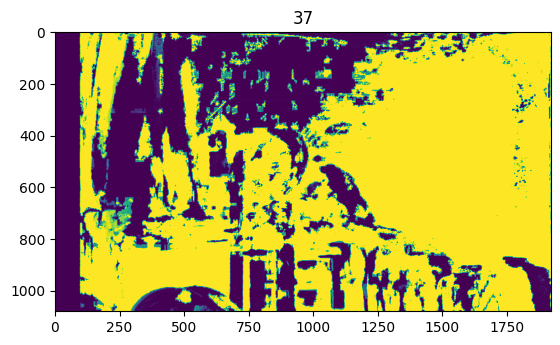

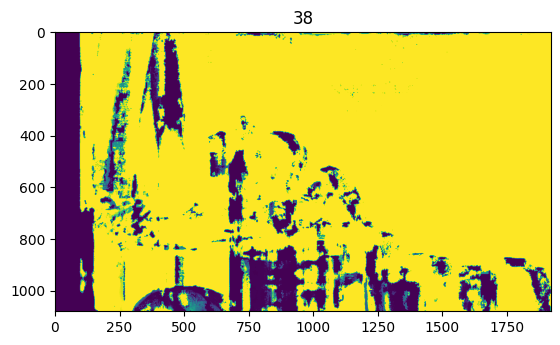

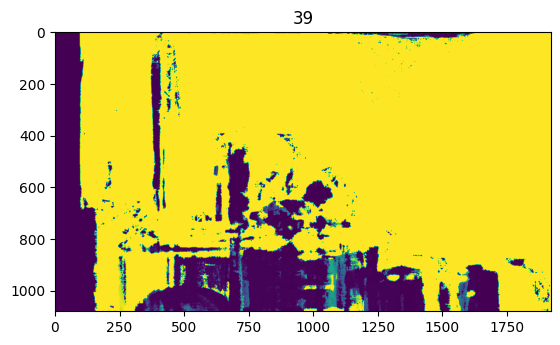

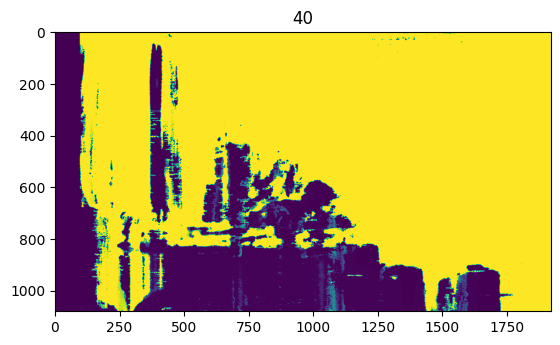

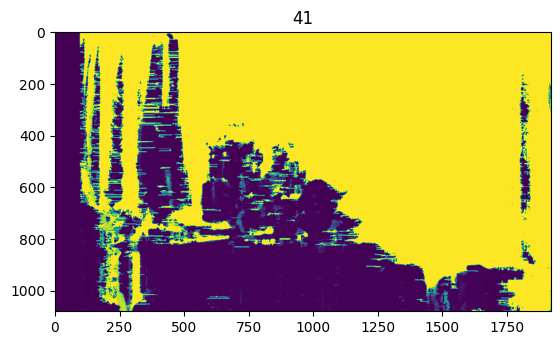

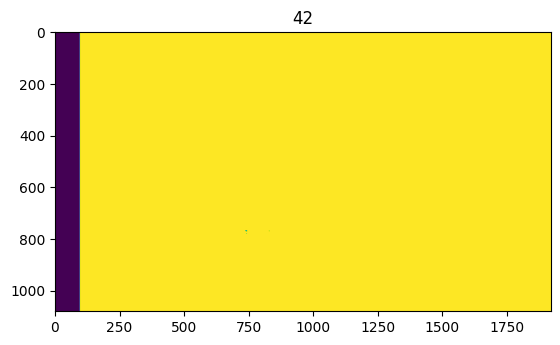

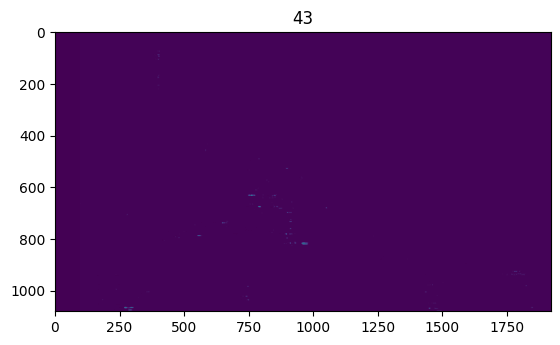

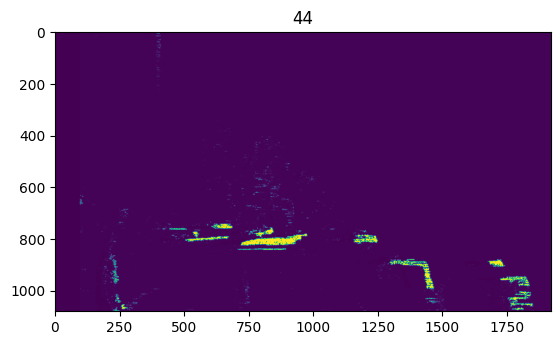

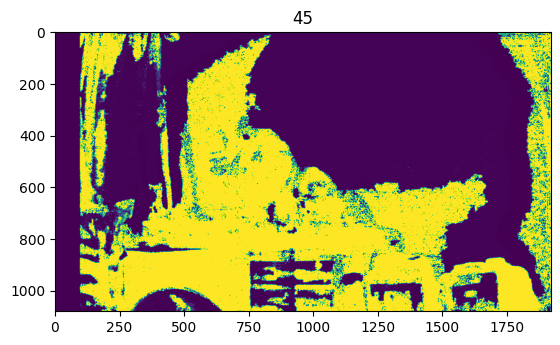

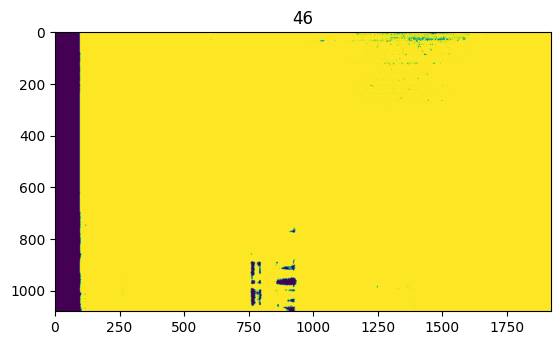

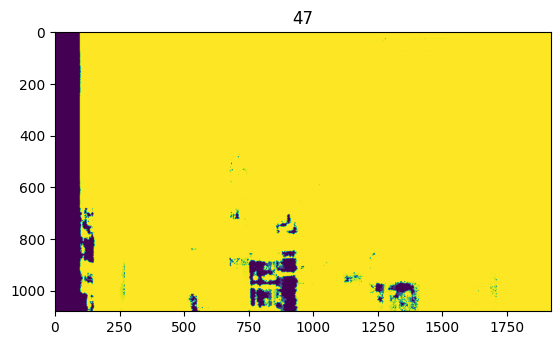

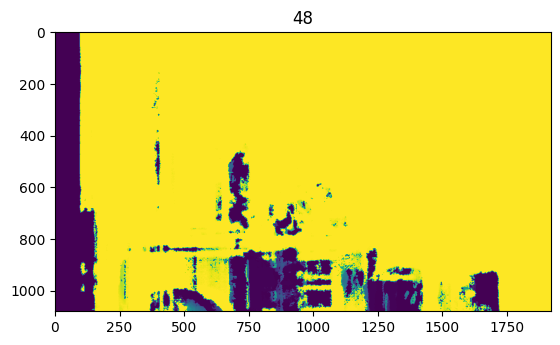

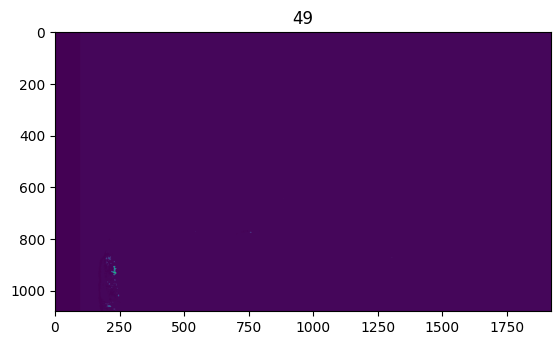

In [47]:
f, ax = plt.subplots(figsize=(10,8))
plt.imshow(gray_l)
# disparity range is tuned for 'aloe' image pair

for window_size in range(1,50):
    # window_size = 6
    stereo = cv2.StereoSGBM_create(minDisparity=1,
                                    numDisparities=96-1,
                                    blockSize=16,
                                    P1=8 * 3 * window_size ** 2,
                                    P2=32 * 3 * window_size ** 2,
                                    disp12MaxDiff=1,
                                    uniquenessRatio=10,
                                    speckleWindowSize=150,
                                    speckleRange=32
                                    )

    # print('computing disparity...')
    disp = stereo.compute(gray_l, gray_r)#.astype(np.float32) / 16.0
    plt.imshow(disp)
    plt.title(f"{window_size}")
    plt.show()